In [18]:
#Imported for handling and managing data
import pandas as pd
import numpy as np
import sklearn


#Imported for Data Cleaning & Feature Identification
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.feature_selection import mutual_info_classif

#Imported to allow testing of train data prior to submission
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from scikitplot.metrics import plot_roc
#scikitplot.metrics.plot_roc

from sklearn.feature_selection import SelectFromModel

#Machine learning models for classification
from sklearn.ensemble import RandomForestClassifier #This one is my favourite :)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import lightgbm as lgb

from sklearn.ensemble import  VotingClassifier
from sklearn.model_selection import StratifiedKFold

#Imported for Graphing
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline


#Because sklearn.impute isn't working :S

from sklearn.preprocessing import imputation

In [19]:
train = pd.read_csv('C:\\Users\\ZS5034\\DataScienceChallenge_France_B2B_Churn\\train.csv', encoding='Latin-1')
test = pd.read_csv('C:\\Users\\ZS5034\\DataScienceChallenge_France_B2B_Churn\\test.csv', encoding='Latin-1')

train_copy = train
test_copy = test

#Groups the input data by dtype
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])
train_obj = train.select_dtypes(include=['O'])

test_float = test.select_dtypes(include=['float64'])
test_int = test.select_dtypes(include=['int64'])
test_obj = test.select_dtypes(include=['O'])

#Groups numeric input data
train_num = pd.concat([train_int, train_float], axis=1)
test_num = pd.concat([test_int, test_float], axis=1)

#Creates missing category fields
train_nan = train_obj[train_obj.columns].isnull().astype(int).add_suffix('_indicator')
train_num = pd.concat([train_num, train_nan], axis=1) 

test_nan = test_obj[test_obj.columns].isnull().astype(int).add_suffix('_indicator')
test_num = pd.concat([test_num, test_nan], axis=1) 

In [20]:
print(train_num.shape)
print(test_num.shape)

(356669, 36)
(79771, 35)


In [21]:
train_num = train_num.fillna(value = 0)

In [22]:
train_num['Volume_deciles'] = pd.qcut(train_num.Volume_annuel,10,labels=False,duplicates='drop')
train_num['Prix_Gaz_M3_deciles'] = pd.qcut(train_num.Prix_Gaz_M3,10,labels=False,duplicates='drop')
train_num['Prix_Elec_M3_deciles'] = pd.qcut(train_num.Prix_Elec_M3,10,labels=False,duplicates='drop')
train_num['anciennetÃ©_client_deciles'] = pd.qcut(train_num['anciennetÃ©_client'].values,10,labels=False,duplicates='drop')
train_num['Pop_quartiles'] = pd.qcut(train_num.Population,4,labels=False,duplicates='drop')

In [23]:
train_num = train_num.drop(['Produit_indicator', 'Type.d.offre_indicator','Canal.de.vente_indicator','MarchÃ©.de.la.SC_indicator','Segment.sociÃ©tÃ©.contractante_indicator','EntitÃ©.sociÃ©tÃ©.contractante_indicator'],axis=1)

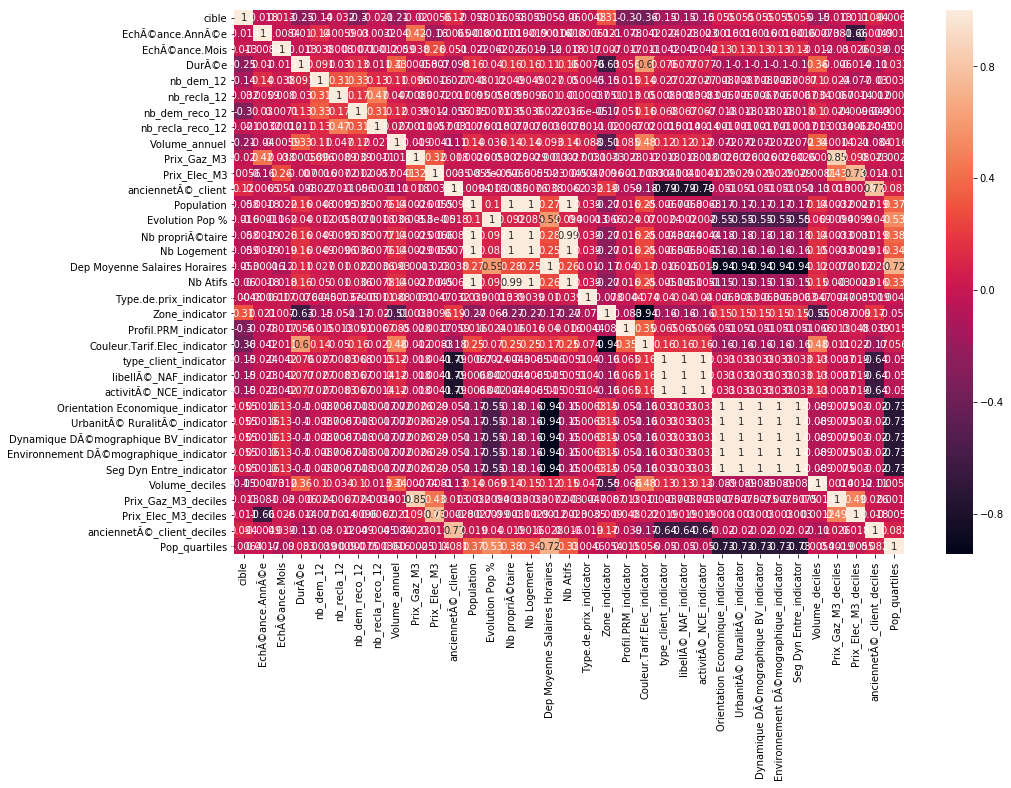

In [25]:
corr = train_num.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot = True)

In [24]:
corr.cible

cible                                     1.000000
EchÃ©ance.AnnÃ©e                         -0.017873
EchÃ©ance.Mois                            0.013407
DurÃ©e                                   -0.245451
nb_dem_12                                -0.135238
nb_recla_12                              -0.032064
nb_dem_reco_12                           -0.301285
nb_recla_reco_12                         -0.020502
Volume_annuel                            -0.206109
Prix_Gaz_M3                              -0.020181
Prix_Elec_M3                              0.005581
anciennetÃ©_client                        0.122540
Population                               -0.058083
Evolution Pop %                          -0.016116
Nb propriÃ©taire                         -0.058236
Nb Logement                              -0.058521
Dep Moyenne Salaires Horaires            -0.052735
Nb Atifs                                 -0.059597
Type.de.prix_indicator                   -0.004764
Zone_indicator                 

In [26]:
#Imputes missing numeric data
my_imputer = SimpleImputer()


train_imp = pd.DataFrame(my_imputer.fit_transform(train_num),columns = train_num.columns)
train_output = train['cible']
test_imp = pd.DataFrame(my_imputer.fit_transform(test_num),columns = test_num.columns)


#my_imputer = SimpleImputer()
#train_imp = pd.DataFrame(my_imputer(train_num),columns = train_num.columns)
#train_output = train['cible']
#test_imp = pd.DataFrame(my_imputer(test_num),columns = test_num.columns)



#Converts text fields in to large number of fields based upon what is in text field i.e. column for each option with 1 if option = true and 0 if option = false
one_hot_encoded_train_obj = pd.get_dummies(train_obj, dummy_na=True)
one_hot_encoded_test_obj = pd.get_dummies(test_obj, dummy_na=True)

#Originally didn't use imputed figures :S
#Joins the imputed numeric DataFrame to bool text fields
train_tot = pd.concat([train_imp, one_hot_encoded_train_obj], axis=1) 
test_tot = pd.concat([test_imp, one_hot_encoded_test_obj], axis=1)

#Only keeps fields in train data which are inlcuded in the test data i.e. no unnessicary fields used to train model
train_cols = list(train_tot.columns)
test_cols = list(test_tot.columns)

found = [i for i in train_cols if i in set(test_cols)]

train_use = train_tot[found]
test_use = test_tot[found]

In [27]:
print(train_use.shape)
print(test_use.shape)

(356669, 642)
(79771, 642)


In [30]:
#train_obj2 = train_obj
#train_obj2 = train_obj2.drop('libellÃ©_NAF',axis=1)
#train_obj2.head()

In [28]:
#one_hot_encoded_train_obj2 = pd.get_dummies(train_obj2)
#one_hot_encoded_train_obj2['cible'] = train.cible

In [32]:
#train_tot = pd.concat([train_imp, one_hot_encoded_train_obj2], axis=1) 
#test_tot = pd.concat([test_imp, one_hot_encoded_test_obj], axis=1)


#Only keeps fields in train data which are inlcuded in the test data i.e. no unnessicary fields used to train model
#train_cols = list(train_tot.columns)
#test_cols = list(test_tot.columns)

#found = [i for i in train_cols if i in set(test_cols)]

#train_use = train_tot[found]
#test_use = test_tot[found]

In [31]:
#corr = pd.concat([train_use, train.cible], axis=1) .corr()

In [29]:
#a = pd.Series(corr.cible)
#a = a.sort_values(axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
#a[a>0.05].index
#['Orientation Economique_nan', 'Environnement DÃ©mographique_nan',       'Seg Dyn Entre_nan', 'Orientation Economique_indicator',       'UrbanitÃ© RuralitÃ©_indicator',       'Dynamique DÃ©mographique BV_indicator', 'UrbanitÃ© RuralitÃ©_nan',       'Environnement DÃ©mographique_indicator',       'Dynamique DÃ©mographique BV_nan', 'Seg Dyn Entre_indicator',       'Type.de.prix_GPRS Prix Fixe', 'Canal.de.vente_Vente physique',       'libellÃ©_NAF_Administration d'immeubles et autres biens immobiliers',       'type_client_dual', 'anciennetÃ©_client',       'activitÃ©_NCE_Services marchands divers (hors santÃ© et enseignement)',       'Type.de.prix_MAITRIZ' 100% fixe', 'Type.d.offre_Grille de prix',       'Segment.sociÃ©tÃ©.contractante_RÃ©sidentiel privÃ©',       'MarchÃ©.de.la.SC_RESIDENTIEL PRIVE', 'Zone_nan', 'Zone_indicator',       'Produit_Elec', 'Profil.PRM_BT < 36 - simple (Simple)',       'Couleur.Tarif.Elec_Bleu', 'cible']

In [33]:
#a[a<-0.05].index
#['Couleur.Tarif.Elec_indicator', 'Couleur.Tarif.Elec_nan', 'Produit_Gaz',       'nb_dem_reco_12', 'Profil.PRM_nan', 'Profil.PRM_indicator', 'DurÃ©e',       'Zone_ZONE NORD', 'Type.de.prix_RÃ©fÃ©rence',       'Type.de.prix_Prix Fixe garanti', 'Volume_annuel',       'Type.d.offre_Prix individualisÃ©', 'MarchÃ©.de.la.SC_TERTIAIRE',       'Profil.PRM_P012', 'Segment.sociÃ©tÃ©.contractante_Tertiaire privÃ©',       'Zone_ZONE SUD', 'type_client_nan', 'type_client_indicator',       'libellÃ©_NAF_nan', 'libellÃ©_NAF_indicator', 'activitÃ©_NCE_indicator',       'activitÃ©_NCE_nan', 'nb_dem_12', 'MarchÃ©.de.la.SC_INDUSTRIE',       'Segment.sociÃ©tÃ©.contractante_Industrie', 'Zone_TIGF',       'Profil.PRM_P016', 'Profil.PRM_P017',       'Canal.de.vente_Vente Ã  distance',       'EntitÃ©.sociÃ©tÃ©.contractante_Entreprises & territoires vente et multicanal',       'Profil.PRM_P018', 'Type.de.prix_Grille de prix fixe',       'libellÃ©_NAF_Location et location-bail d'autres biens personnels et domes',       'Profil.PRM_P019', 'Nb Atifs', 'Nb Logement', 'Nb propriÃ©taire',       'Population', 'Dep Moyenne Salaires Horaires']

In [35]:
#from sklearn.ensemble import ExtraTreesClassifier
#X = train_use
#Y = train.cible
# feature extraction
#model = ExtraTreesClassifier(n_estimators = 10)
#model.fit(X, Y)
#print(model.feature_importances_)

#a = pd.DataFrame(model.feature_importances_)
#a['cols'] = train_use.columns

#model = ExtraTreesClassifier(n_estimators = 10)
#model.fit(X, Y)
#print(model.feature_importances_)
#a['10run'] = pd.DataFrame(model.feature_importances_)
#a.to_csv("feature_importances.csv",index=False)

In [34]:
#All fields with correlation either > or < then 0.05
#train_final_cols = ['Orientation Economique_nan','Environnement DÃ©mographique_nan','Seg Dyn Entre_nan','Orientation Economique_indicator','UrbanitÃ© RuralitÃ©_indicator','Dynamique DÃ©mographique BV_indicator', 'UrbanitÃ© RuralitÃ©_nan','Environnement DÃ©mographique_indicator','Dynamique DÃ©mographique BV_nan', 'Seg Dyn Entre_indicator',       'Type.de.prix_GPRS Prix Fixe', 'Canal.de.vente_Vente physique',       "libellÃ©_NAF_Administration d'immeubles et autres biens immobiliers",       'type_client_dual', 'anciennetÃ©_client',       'activitÃ©_NCE_Services marchands divers (hors santÃ© et enseignement)',       "Type.de.prix_MAITRIZ' 100% fixe", 'Type.d.offre_Grille de prix',       'Segment.sociÃ©tÃ©.contractante_RÃ©sidentiel privÃ©',       'MarchÃ©.de.la.SC_RESIDENTIEL PRIVE', 'Zone_nan', 'Zone_indicator',       'Produit_Elec', 'Profil.PRM_BT < 36 - simple (Simple)',       'Couleur.Tarif.Elec_Bleu','Couleur.Tarif.Elec_indicator', 'Couleur.Tarif.Elec_nan', 'Produit_Gaz',       'nb_dem_reco_12', 'Profil.PRM_nan', 'Profil.PRM_indicator', 'DurÃ©e',       'Zone_ZONE NORD', 'Type.de.prix_RÃ©fÃ©rence',       'Type.de.prix_Prix Fixe garanti', 'Volume_annuel',       'Type.d.offre_Prix individualisÃ©', 'MarchÃ©.de.la.SC_TERTIAIRE',       'Profil.PRM_P012', 'Segment.sociÃ©tÃ©.contractante_Tertiaire privÃ©',       'Zone_ZONE SUD', 'type_client_nan', 'type_client_indicator',       'libellÃ©_NAF_nan', 'libellÃ©_NAF_indicator', 'activitÃ©_NCE_indicator',       'activitÃ©_NCE_nan', 'nb_dem_12', 'MarchÃ©.de.la.SC_INDUSTRIE',       'Segment.sociÃ©tÃ©.contractante_Industrie', 'Zone_TIGF',       'Profil.PRM_P016', 'Profil.PRM_P017',       'Canal.de.vente_Vente Ã  distance',       'EntitÃ©.sociÃ©tÃ©.contractante_Entreprises & territoires vente et multicanal',       'Profil.PRM_P018', 'Type.de.prix_Grille de prix fixe',       "libellÃ©_NAF_Location et location-bail d'autres biens personnels et domes",       'Profil.PRM_P019', 'Nb Atifs', 'Nb Logement', 'Nb propriÃ©taire',       'Population', 'Dep Moyenne Salaires Horaires']

#All fields to get feature importance >95% n=10
#train_final_cols = ['Prix_Elec_M3','Prix_Gaz_M3','EchÃƒÂ©ance.AnnÃƒÂ©e','EchÃƒÂ©ance.Mois','nb_dem_reco_12','Volume_annuel','nb_dem_12','Nb Atifs','Nb propriÃƒÂ©taire','Population','Dep Moyenne Salaires Horaires','Nb Logement','DurÃƒÂ©e','Couleur.Tarif.Elec_indicator','anciennetÃƒÂ©_client','Evolution Pop %','Profil.PRM_nan','Profil.PRM_BT < 36 - simple (Simple)','Couleur.Tarif.Elec_Bleu','Zone_nan','Zone_ZONE NORD','Profil.PRM_indicator','Zone_indicator','Type.de.prix_Prix Fixe garanti','MarchÃƒÂ©.de.la.SC_TERTIAIRE','type_client_indicator','Couleur.Tarif.Elec_nan','type_client_nan','Zone_ZONE SUD','libellÃƒÂ©_NAF_nan','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires vente et multicanal','Canal.de.vente_Vente physique','type_client_gaz','Type.d.offre_Grille de prix','Profil.PRM_P012','UrbanitÃƒÂ© RuralitÃƒÂ©_Com > 200 m habts','MarchÃƒÂ©.de.la.SC_RESIDENTIEL PRIVE','Type.de.prix_RÃƒÂ©fÃƒÂ©rence','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires Nord Est','Profil.PRM_P016','UrbanitÃƒÂ© RuralitÃƒÂ©_Com < 200 m habts','activitÃƒÂ©_NCE_nan','Segment.sociÃƒÂ©tÃƒÂ©.contractante_Tertiaire privÃƒÂ©','Type.d.offre_Prix individualisÃƒÂ©','type_client_dual','Type.de.prix_GPRS Prix Fixe','type_client_ÃƒÂ©lec','UrbanitÃƒÂ© RuralitÃƒÂ©_Com < 50 m habts','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires IDF','Canal.de.vente_Vente ÃƒÂ  distance',"Type.de.prix_MAITRIZ' 100% fixe",'Type.de.prix_Prix Fixe','Profil.PRM_P017','Profil.PRM_P019','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires Sud Est','Profil.PRM_P018','Segment.sociÃƒÂ©tÃƒÂ©.contractante_Industrie','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires Grand Ouest','Produit_Gaz','Segment.sociÃƒÂ©tÃƒÂ©.contractante_RÃƒÂ©sidentiel privÃƒÂ©',"libellÃƒÂ©_NAF_Administration d'immeubles et autres biens immobiliers",'Zone_TIGF','UrbanitÃƒÂ© RuralitÃƒÂ©_Com < 10 m habts','Seg Dyn Entre_Dynamique Economique','Dynamique DÃƒÂ©mographique BV_1.Accroissement par excÃƒÂ©dent naturel et migratoire','libellÃƒÂ©_NAF_Agences immobiliÃƒÂ¨res','libellÃƒÂ©_NAF_indicator','nb_recla_12','activitÃƒÂ©_NCE_indicator','Profil.PRM_P011','UrbanitÃƒÂ© RuralitÃƒÂ©_Com rurale < 2 000 m habts','MarchÃƒÂ©.de.la.SC_INDUSTRIE','activitÃƒÂ©_NCE_Services marchands divers (hors santÃƒÂ© et enseignement)','Seg Dyn Entre_Faible dynamique','Profil.PRM_P015','Profil.PRM_P014','Environnement DÃƒÂ©mographique_Bassin RÃƒÂ©sidentiel en croissance dÃƒÂ©mographique','Profil.PRM_BT < 36- double (HP HC)','Dynamique DÃƒÂ©mographique BV_Grande Ville','Orientation Economique_Bassin Industriel','Orientation Economique_Bassin RÃƒÂ©sidentiel','Environnement DÃƒÂ©mographique_Bassin Industriel en croissance dÃƒÂ©mographique',"libellÃƒÂ©_NAF_Location et location-bail d'autres biens personnels et domes",'Dynamique DÃƒÂ©mographique BV_3.Accroissement par excÃƒÂ©dent migratoire','Dynamique DÃƒÂ©mographique BV_6.DÃƒÂ©clin par dÃƒÂ©ficit migratoire','Seg Dyn Entre_Moyenne dynamique','Orientation Economique_Bassin Urbain','libellÃƒÂ©_NAF_Action sociale sans hÃƒÂ©bergement n.c.a.']

#All fields to get feature importance >95% n=100
train_final_cols = ['Prix_Elec_M3','Prix_Gaz_M3','EchÃƒÂ©ance.AnnÃƒÂ©e','EchÃƒÂ©ance.Mois','Volume_annuel','nb_dem_reco_12','nb_dem_12','DurÃƒÂ©e','Population','Nb Logement','Nb propriÃƒÂ©taire','Nb Atifs','Couleur.Tarif.Elec_Bleu','Dep Moyenne Salaires Horaires','anciennetÃƒÂ©_client','Evolution Pop %','Couleur.Tarif.Elec_nan','Profil.PRM_indicator','Profil.PRM_nan','Couleur.Tarif.Elec_indicator','Profil.PRM_BT < 36 - simple (Simple)','Produit_Elec','Zone_ZONE NORD','MarchÃƒÂ©.de.la.SC_RESIDENTIEL PRIVE','Type.de.prix_RÃƒÂ©fÃƒÂ©rence','Zone_nan','type_client_gaz','Profil.PRM_P012','Type.d.offre_Grille de prix','type_client_nan','Zone_indicator','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires vente et multicanal','Segment.sociÃƒÂ©tÃƒÂ©.contractante_RÃƒÂ©sidentiel privÃƒÂ©','Canal.de.vente_Vente ÃƒÂ  distance','type_client_indicator','libellÃƒÂ©_NAF_indicator','Canal.de.vente_Vente physique','UrbanitÃƒÂ© RuralitÃƒÂ©_Com > 200 m habts','MarchÃƒÂ©.de.la.SC_TERTIAIRE','Type.de.prix_GPRS Prix Fixe','Type.de.prix_Prix Fixe garanti','Zone_ZONE SUD','activitÃƒÂ©_NCE_indicator','Type.d.offre_Prix individualisÃƒÂ©','Segment.sociÃƒÂ©tÃƒÂ©.contractante_Tertiaire privÃƒÂ©','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires IDF','UrbanitÃƒÂ© RuralitÃƒÂ©_Com < 200 m habts','type_client_ÃƒÂ©lec','Profil.PRM_P016','Produit_Gaz','UrbanitÃƒÂ© RuralitÃƒÂ©_Com < 50 m habts','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires Nord Est','Profil.PRM_P017',"Type.de.prix_MAITRIZ' 100% fixe",'Type.de.prix_Prix Fixe','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires Sud Est','type_client_dual','activitÃƒÂ©_NCE_nan','Profil.PRM_P018','Profil.PRM_P019','EntitÃƒÂ©.sociÃƒÂ©tÃƒÂ©.contractante_Entreprises & territoires Grand Ouest','Zone_TIGF',"libellÃƒÂ©_NAF_Administration d'immeubles et autres biens immobiliers",'UrbanitÃƒÂ© RuralitÃƒÂ©_Com < 10 m habts','Seg Dyn Entre_Dynamique Economique']

In [36]:
#Only includes the most important both fields to train the model from feature importance
#train_final_cols = ['Type.de.prix_GPRS Prix Fixe', 'Canal.de.vente_Vente physique',       'type_client_dual',       'activitÃ©_NCE_Services marchands divers (hors santÃ© et enseignement)',       'Type.de.prix_MAITRIZ 100% fixe', 'Type.d.offre_Grille de prix',       'Segment.sociÃ©tÃ©.contractante_RÃ©sidentiel privÃ©',       'MarchÃ©.de.la.SC_RESIDENTIEL PRIVE', 'Produit_Elec',       'Profil.PRM_BT < 36 - simple (Simple)', 'Couleur.Tarif.Elec_Bleu',                'Produit_Gaz', 'nb_dem_reco_12', 'DurÃ©e', 'Zone_ZONE NORD',       'Type.de.prix_RÃ©fÃ©rence', 'Type.de.prix_Prix Fixe garanti',       'Volume_annuel', 'Type.d.offre_Prix individualisÃ©',       'MarchÃ©.de.la.SC_TERTIAIRE', 'Profil.PRM_P012',       'Segment.sociÃ©tÃ©.contractante_Tertiaire privÃ©', 'Zone_ZONE SUD',       'nb_dem_12', 'Segment.sociÃ©tÃ©.contractante_Industrie',       'MarchÃ©.de.la.SC_INDUSTRIE', 'Zone_TIGF', 'Profil.PRM_P016',       'Profil.PRM_P017', 'Canal.de.vente_Vente Ã  distance',       'EntitÃ©.sociÃ©tÃ©.contractante_Entreprises & territoires vente et multicanal',       'Profil.PRM_P018', 'Type.de.prix_Grille de prix fixe',       'Profil.PRM_P019', 'Nb Atifs', 'Nb Logement'   ]

In [37]:
#Only includes the most important both fields to train the model from feature importance
#train_final_cols = [65, 17, 52, 19, 40, 44, 2, 582, 7, 609, 68, 27, 34, 606, 588, 603, 18, 113, 10, 11]

train_final = train_use.loc[:,train_final_cols]
#train_final['type_client'] = train_copy['type_client']

test_final = test_use.loc[:,train_final_cols]
train_final.head()

train_final = train_final.fillna(value=0)
test_final = test_final.fillna(value=0)

C:\Python\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [38]:
print(len(train_final_cols))
print(train_final.shape)
print(test_final.shape)

65
(356669, 65)
(79771, 65)


In [39]:
#Remaps final data
X = train_final
X.columns = range(0,len(X.columns))
#X.columns = train_final_cols

#Y = pd.factorize(train.cible.values)[0].reshape(-1, 1)
Y = train.cible
#Y.columns = range(0,len(Y.columns))

Z = test_final
Z.columns = range(0,len(Z.columns))
#Z.columns = train_final_cols

#Parameters for splitting data into train and test sets
seed = 7
test_size = 0.40
#Splits the data in to 4 Groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

#X_train.columns = train_final_cols
#X_test.columns = train_final_cols

Start training...
[1]	valid_0's l1: 0.0555517	valid_0's binary_logloss: 0.114838
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l1: 0.0545885	valid_0's binary_logloss: 0.107751
[3]	valid_0's l1: 0.053688	valid_0's binary_logloss: 0.102667
[4]	valid_0's l1: 0.0528338	valid_0's binary_logloss: 0.0984902
[5]	valid_0's l1: 0.0520256	valid_0's binary_logloss: 0.0951187
[6]	valid_0's l1: 0.0512439	valid_0's binary_logloss: 0.0921967
[7]	valid_0's l1: 0.0505176	valid_0's binary_logloss: 0.0895552
[8]	valid_0's l1: 0.0498348	valid_0's binary_logloss: 0.0870632
[9]	valid_0's l1: 0.0491837	valid_0's binary_logloss: 0.0849906
[10]	valid_0's l1: 0.048544	valid_0's binary_logloss: 0.0830857
[11]	valid_0's l1: 0.0479361	valid_0's binary_logloss: 0.0814111
[12]	valid_0's l1: 0.0473483	valid_0's binary_logloss: 0.0798752
[13]	valid_0's l1: 0.0467966	valid_0's binary_logloss: 0.0785011
[14]	valid_0's l1: 0.0462648	valid_0's binary_logloss: 0.0771878
[15]	valid_0's l1: 0.0457

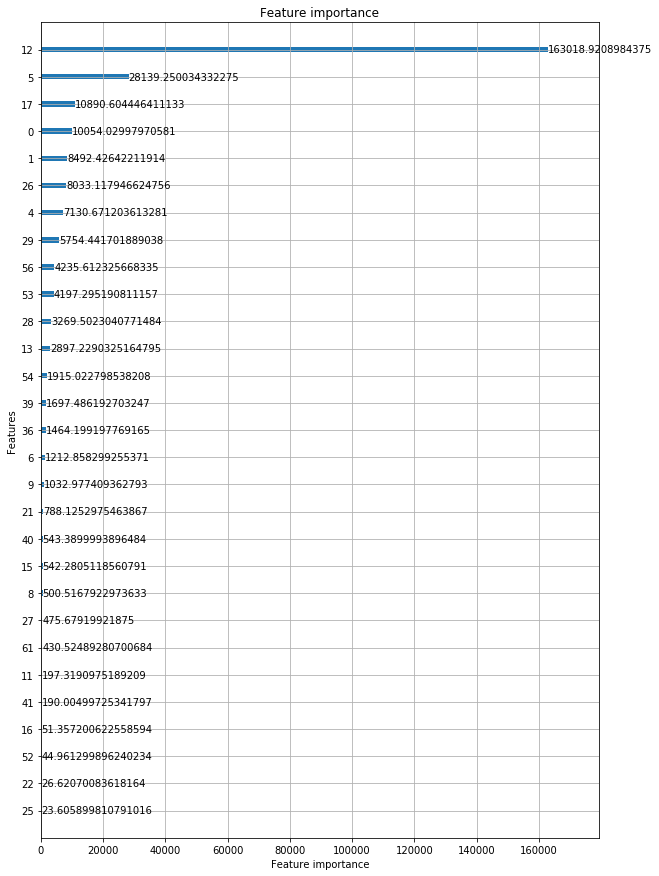

In [40]:
print('Start training...')
# train
gbm = lgb.LGBMClassifier(objective='binary',num_leaves=31,learning_rate=0.05,n_estimators=20,)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=5)

print('Start predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# feature importances
print('Feature importances:', list(gbm.feature_importances_))

print('Plot feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=len(train_final_cols),figsize=(10,15),importance_type='gain')
plt.show()

In [41]:
# fits XGBoost model to training data
XGBoostmodel = XGBClassifier(booster='gbtree',
    n_estimators = 100,
    silent=1,
    eta=0.3,
    min_child_weight=15,
    max_depth=10,
    gamma=0,
    max_delta_step=0,
    subsample=1,
    colsample_bytree=1,
    colsample_bylevel =1,
    alpha=0,
    scale_pos_weight=1,
    objective = 'reg:linear',
    eval_metric = 'auc', #rmse,mae,logloss,error,merror,mlogloss,auc
    seed=0
)

XGBoostmodel.fit(X_train, y_train)

# make predictions for test data
XGBoostmodel_pred = XGBoostmodel.predict(X_test)
XGBoostmodel_prob = XGBoostmodel.predict_proba(X_test)

Accuracy: 97.99%
ROC AUC SCORE: 88.51%


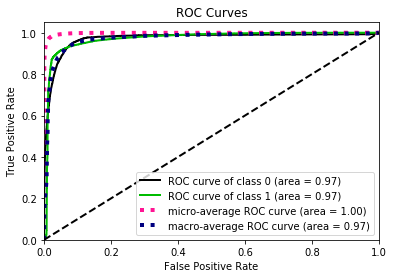

In [42]:
# evaluate predictions
accuracy = accuracy_score(XGBoostmodel_pred, y_test)
ROC = roc_auc_score(XGBoostmodel_pred, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC SCORE: %.2f%%" % (ROC * 100.0))
plot_roc(y_test, XGBoostmodel_prob)
plt.show()

In [43]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [ ]:
from time import time
from scipy.stats import randint

from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb

#from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import balanced_accuracy_score

In [ ]:
#Define process for tuning hyperparameters

def hypertuning_rscv(est, p_distr, X, y):
    rdmsearch = GridSearchCV(est,  param_grid=p_distr, n_jobs=-1, scoring = 'r2', cv=5,return_train_score=True)
    start = time()
    rdmsearch.fit(X,y)
    print('hyper-tuning time : %d seconds' % (time()-start))
    start = 0
    ht_params = rdmsearch.best_params_
    ht_score = rdmsearch.best_score_
    ht_results = rdmsearch.cv_results_
    return ht_params, ht_score, ht_results


sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [ ]:
#Specify model & parameters for processing
est = RandomForestClassifier(n_jobs=-1)

rf_p_dist={'max_depth':[3,5,10,None],
           'max_features':[1,5,10,15],
           'criterion':['gini','entropy'],
           'bootstrap':[True,False],
           'min_samples_leaf':[1,5,10,15,20,25],
           'n_estimators': [100,250]
           }

rf_parameters, rf_ht_score, rf_ht_results = hypertuning_rscv(est, rf_p_dist, X_train, np.ravel(y_train))

rf_parameters['n_jobs']=-1 #Using all processors

print(rf_parameters)
print('Hyper-tuned model score :')
print(rf_ht_score)

In [ ]:
#y_test = random_search.predict_proba(test)
#results_df = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
#results_df.to_csv('submission-random-grid-search-xgb-porto-01.csv', index=False)

In [ ]:
# Fits Random Forest model to training data
#RandomForestmodelGini = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=None, min_samples_split=15, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
RandomForestmodelGini = RandomForestClassifier(**rf_parameters)
RandomForestmodelGini.fit(X_train, y_train)

# make predictions for test data
RandomForestmodelGini_pred = RandomForestmodelGini.predict(X_test)
RandomForestmodelGini_prob = RandomForestmodelGini.predict_proba(X_test)

In [ ]:
# evaluate predictions
accuracy = accuracy_score(RandomForestmodelGini_pred, y_test)
ROC = roc_auc_score(RandomForestmodelGini_pred, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC SCORE: %.2f%%" % (ROC * 100.0))
plot_roc(y_test, RandomForestmodelGini_prob)
plt.show()

In [ ]:
# Fits Random Forest model to training data
#RandomForestmodelEntropy = RandomForestClassifier(n_estimators=200, criterion='entropy', max_depth=None, min_samples_split=15, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)
#RandomForestmodelEntropy.fit(X_train, y_train)

# make predictions for test data
#RandomForestmodelEntropy_pred = RandomForestmodelEntropy.predict(X_test)
#RandomForestmodelEntropy_prob = RandomForestmodelEntropy.predict_proba(X_test)

In [ ]:
# evaluate predictions
#accuracy = accuracy_score(RandomForestmodelEntropy_pred, y_test)
#ROC = roc_auc_score(RandomForestmodelEntropy_pred, y_test)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
#print("ROC AUC SCORE: %.2f%%" % (ROC * 100.0))
#plot_roc(y_test, RandomForestmodelEntropy_prob)
#plt.show()

In [ ]:
# Fits CatBoost model to training data


#Specify model & parameters for processing
est = CatBoostClassifier()

Cat_p_dist={'iterations':[100,150,200]
           'learning_rate':[0.05,0.1,0.2,0.3]
           'depth':[3,5,10,None],
           'loss_function':['CrossEntropy','Logloss'],
           'bagging_temperature':[0.25,0.5,0.75]
           }

Cat_parameters, Cat_ht_score, Cat_ht_results = hypertuning_rscv(est, Cat_p_dist, X_train, np.ravel(y_train))

#Cat_parameters['n_jobs']=-1 #Using all processors

print(Cat_parameters)
print('Hyper-tuned model score :')
print(Cat_ht_score)

CatBoostmodel = CatBoostClassifier(**Cat_parameters)
CatBoostmodel.fit(X_train, y_train)

# make predictions for test data
CatBoostmodel_pred = CatBoostmodel.predict(X_test)
CatBoostmodel_prob = CatBoostmodel.predict_proba(X_test)

In [ ]:
# evaluate predictions
accuracy = accuracy_score(CatBoostmodel_pred, y_test)
ROC = roc_auc_score(CatBoostmodel_pred, y_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("ROC AUC SCORE: %.2f%%" % (ROC * 100.0))
plot_roc(y_test, CatBoostmodel_prob)
plt.show()

In [ ]:
gbm.fit(X, Y)
XGBoostmodel.fit(X, Y)
RandomForestmodelGini.fit(X, Y)
RandomForestmodelEntropy.fit(X, Y)
CatBoostmodel.fit(X, Y)

In [ ]:
gbmmodel_prob = gbm.predict_proba(Z)
XGBoostmodel_prob = XGBoostmodel.predict_proba(Z)
RandomForestmodelGini_prob = RandomForestmodelGini.predict_proba(Z)
RandomForestmodelEntropy_prob = RandomForestmodelEntropy.predict_proba(Z)
CatBoostmodel_prob = CatBoostmodel.predict_proba(Z)

In [ ]:
output = pd.DataFrame(gbmmodel_prob[:,1])
output['XGBoostmodel_prob'] = pd.DataFrame(XGBoostmodel_prob[:,1])
output['RandomForestmodelGini_prob'] = RandomForestmodelGini_prob[:,1]
output['RandomForestmodelEntropy_prob'] = RandomForestmodelEntropy_prob[:,1]
output['CatBoostmodel_prob'] = CatBoostmodel_prob[:,1]

In [ ]:
output.to_csv("output.csv",index=False, header=False)

End = datetime.now()
print(Start)
print(End)
print(End-Start)